In [3]:
# from binance.client import Client # python-binance
# from binance.spot import Spot #!pip install binance-connector
# import pickle
# import ccxt
# import requests
# import time
# import requests
# from datetime import datetime
# import pandas as pd
# from tqdm import tqdm
# import math
# import numpy as np
# import matplotlib.pyplot as plt

## 데이터 로드

In [4]:
def bin_sym_names():#바이낸스 심볼명들 도출
    result = requests.get('https://api.binance.com/api/v3/ticker/price')
    js = result.json()
    symbols = [x['symbol'] for x in js]
    symbols_usdt = [x for x in symbols if 'USDT' in x]  # 끝이 USDT로 끝나는 심볼들, ['BTCUSDT', 'ETHUSDT', ...]
    return symbols_usdt

def bin_get_data(start_date, end_date, symbol , interval): # 시작일 , 종료일 , 심볼명 , 분/시간/일/주/월 데이터 선택
    URL = 'https://api.binance.com/api/v3/klines'
    
    COLUMNS = ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'quote_av', 'trades', 
               'tb_base_av', 'tb_quote_av', 'ignore']
    data = []
    
    start = int(time.mktime(datetime.strptime(start_date + ' 00:00', '%Y-%m-%d %H:%M').timetuple())) * 1000
    end = int(time.mktime(datetime.strptime(end_date +' 23:59', '%Y-%m-%d %H:%M').timetuple())) * 1000
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': 1000,
        'startTime': start,
        'endTime': end
    }
    
    while start < end:
#         print(datetime.fromtimestamp(start // 1000))
        params['startTime'] = start
        result = requests.get(URL, params = params)
        js = result.json()
        if not js:
            break
        data.extend(js)  # result에 저장
        start = js[-1][0] + 60000  # 다음 step으로
    # 전처리
    if not data:  # 해당 기간에 데이터가 없는 경우
        print('해당 기간에 일치하는 데이터가 없습니다.')
        return -1
    df = pd.DataFrame(data)
    df.columns = COLUMNS
    df['Open_time'] = df.apply(lambda x:datetime.fromtimestamp(x['Open_time'] // 1000), axis=1)
    df = df.drop(columns = ['Close_time', 'ignore'])
    df['Symbol'] = symbol
    df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float
    df['trades'] = df['trades'].astype(int)
    
    # df['Open_time'] = pd.to_datetime(df['Open_time'], format='%Y-%m-%d %H:%M:%S', errors='raise')
    # df = df.set_index('Open_time',drop=True)
    return df


In [5]:
import math #math 모듈을 먼저 import해야 한다.    
    # 데이터 프레임 모든 컬럼 그리기
    # 함수명으로도 정의하기
def columns_plot(data): # y좌표
    
#     col_list_plt = list(data.select_dtypes(exclude = "object").columns)
    col_list_plt = list(data.select_dtypes(include = ["float","int"]).columns)
    x_plt_n = 3 # 한번에 그릴 plt x 축 수
    y_plt_n = 4 # 한번에 그릴 plt y 축 수
    w_space = 0.2 # float("0."+str(x_plt_n)
    h_space = 0.2 # float("0."+str(y_plt_n)
    
    if (x_plt_n < math.ceil(len(col_list_plt) / y_plt_n)):
        x_plt_n = math.ceil(len(col_list_plt) / y_plt_n)

    #plot 이쁘게 
    f, axes = plt.subplots(x_plt_n, y_plt_n)
    f.set_size_inches((20, 15))
    plt.subplots_adjust(wspace = w_space, hspace = h_space)

    for i in range(len(col_list_plt)):

        bb = math.ceil(((i )// y_plt_n))
        axes[bb][i - math.ceil(((i )// y_plt_n)) * y_plt_n].plot(data[col_list_plt[i]],label = col_list_plt[i] )#, color = 'blue', marker = 'o')
        axes[bb][i - math.ceil(((i )// y_plt_n)) * y_plt_n].set_title(col_list_plt[i])
    plt.show()
    


In [6]:
from datetime import datetime
import datetime as dt

def about_time_start(day_or_time=10): # 뺼 날자
    now_time = datetime.now()
    diff_days = dt.timedelta(days=day_or_time) # @ 일단 day로 되어 있음.
    
    start_date = (now_time - diff_days).strftime("%Y-%m-%d") # 오늘 부터 몇 일 전
    now_day_time = now_time.strftime("%Y-%m-%d") #현재 날짜
    
    return now_day_time, start_date # start_date = now_time - diff_days

# from datetime import datetime
# now_time = datetime.now()
# now_day_time = datetime.now().strftime("%Y-%m-%d") # 연- 월 - 일
# current_time = datetime.now().strftime("%H:%M:%S") # 시간 - 분 - 초

In [5]:
# 바이낸스 상장 심볼명 (현물) 데이터 가져옮
bin_sym_name = bin_sym_names() # bin_sym_name = symbols_usdt

# 시작~끝일 데이터 가져옮
end_date, start_date = about_time_start(day_or_time = 100)

start_date = str(start_date)#'2017-01-01' # 시작일 (2017 년도 부터 가능)
end_date = str(end_date)#'2022-12-31' # 종료일
interval = "15m"  #  ,'4h',"1m" 
symbol = bin_sym_name[8] # 숫자만 바꾸면 다른 코인 데이터 가져롬

In [6]:
def close_or_open_or_mix(a): # @시시 종 은 아직.
    if a == "시가":
        return "Open"
    elif a == "종가":
        return "Close"

In [7]:
data = {}
sym_i = 8


# close_or_open = close_or_open_or_mix(str(input()))#시가 / 종가 기준..
close_or_open = close_or_open_or_mix("종가")#시가 / 종가 기준..
data[bin_sym_name[sym_i]] = bin_get_data(start_date, end_date, symbol , interval) # @@ 모든데이터 data에 저장하기 위해 딕셔너리 형태로 받음. 추후에 변경 가능

C:\Users\Happy\AppData\Local\Temp\ipykernel_28756\625420528.py:43: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float


In [8]:
data[bin_sym_name[sym_i]]

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol
0,2022-11-15 00:00:00,0.3462,0.3473,0.3454,0.3472,4153341.0,1.438779e+06,2861,1550789.0,537353.0222,XRPUSDT
1,2022-11-15 00:15:00,0.3472,0.3473,0.3427,0.3436,4766114.0,1.643938e+06,3027,1966449.0,678495.6835,XRPUSDT
2,2022-11-15 00:30:00,0.3435,0.3454,0.3420,0.3448,3929989.0,1.351865e+06,2703,1695072.0,583027.1313,XRPUSDT
3,2022-11-15 00:45:00,0.3447,0.3468,0.3445,0.3460,3054761.0,1.056559e+06,2188,1310852.0,453426.9692,XRPUSDT
4,2022-11-15 01:00:00,0.3460,0.3469,0.3431,0.3438,3983032.0,1.375401e+06,3072,1804704.0,623385.6430,XRPUSDT
...,...,...,...,...,...,...,...,...,...,...,...
9664,2023-02-23 16:00:00,0.3939,0.3947,0.3936,0.3945,3324291.0,1.310525e+06,1338,2502460.0,986465.1681,XRPUSDT
9665,2023-02-23 16:15:00,0.3945,0.3964,0.3944,0.3962,2893597.0,1.144891e+06,1287,1773155.0,701364.1576,XRPUSDT
9666,2023-02-23 16:30:00,0.3962,0.3964,0.3955,0.3959,1794113.0,7.106125e+05,919,988521.0,391585.4934,XRPUSDT
9667,2023-02-23 16:45:00,0.3959,0.3965,0.3953,0.3964,2699369.0,1.068973e+06,1097,1244073.0,492734.7936,XRPUSDT


In [9]:
df = data[bin_sym_name[sym_i]].loc[:,["Open_time",close_or_open,"Volume"]]

In [10]:
# 단순 이동 평균(Simple Moving Average, SMA)
def SMA(data, period=30, column='Close'):
    return data[column].rolling(window=period).mean()


In [11]:
WINDOW = [6, 20 ,37 , 74 ,149] # 이평선 여러개 도출
for WINDOW_i in WINDOW:
    data[bin_sym_name[sym_i]]["단순이동평균_"+str(close_or_open)+str(WINDOW_i)] = SMA(data[bin_sym_name[sym_i]], period=WINDOW_i, column=close_or_open)

In [12]:
def Bollinger_Band(df, period=30, column='Close',multiplier = 2):
    
    df['Bollinger_Band_'+str(period)+'_mid_'+str(multiplier) ] = df['Close'].rolling(period).mean() # 20일 이동평균
    df['stddev'] = df['Close'].rolling(period).std() # 20일 이동표준편차
    df['Bollinger_Band_'+str(period)+'upper_'+str(multiplier) ] = df['Bollinger_Band_'+str(period)+'_mid_'+str(multiplier) ] + multiplier*df['stddev'] # 상단밴드
    df['Bollinger_Band_'+str(period)+'lower_'+str(multiplier) ] = df['Bollinger_Band_'+str(period)+'_mid_'+str(multiplier) ] - multiplier*df['stddev'] # 하단밴드
    del df['stddev']

    return df

In [13]:
BB_period = 20 #볼벤
BB_multiplier = 2#볼벤 승수 (std * BB_multiplier)
Bollinger_Band(data[bin_sym_name[sym_i]], period=BB_period, column=close_or_open,multiplier = BB_multiplier)

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol,단순이동평균_Close6,단순이동평균_Close20,단순이동평균_Close37,단순이동평균_Close74,단순이동평균_Close149,Bollinger_Band_20_mid_2,Bollinger_Band_20upper_2,Bollinger_Band_20lower_2
0,2022-07-24 00:00:00,0.3534,0.3555,0.3532,0.3552,1487889.0,5.276243e+05,1250,785128.0,278377.3817,XRPUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-07-24 00:15:00,0.3552,0.3553,0.3535,0.3538,1054541.0,3.739812e+05,900,423040.0,150013.1618,XRPUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-07-24 00:30:00,0.3538,0.3549,0.3533,0.3542,1323092.0,4.685651e+05,930,600935.0,212840.6248,XRPUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-07-24 00:45:00,0.3542,0.3549,0.3538,0.3548,1262203.0,4.472599e+05,1033,643335.0,227937.4708,XRPUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-07-24 01:00:00,0.3548,0.3556,0.3543,0.3555,1465355.0,5.199971e+05,1088,761912.0,270403.9649,XRPUSDT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9665,2022-11-01 16:15:00,0.4613,0.4615,0.4593,0.4595,2688969.0,1.237139e+06,1441,1256706.0,578137.9316,XRPUSDT,0.460900,0.459675,0.460535,0.457215,0.457735,0.459675,0.462264,0.457086
9666,2022-11-01 16:30:00,0.4595,0.4608,0.4595,0.4600,2375442.0,1.092986e+06,1299,914751.0,420873.2932,XRPUSDT,0.460617,0.459615,0.460419,0.457208,0.457723,0.459615,0.462109,0.457121
9667,2022-11-01 16:45:00,0.4600,0.4606,0.4598,0.4603,2088740.0,9.612772e+05,1024,751531.0,345832.2255,XRPUSDT,0.460417,0.459665,0.460403,0.457219,0.457709,0.459665,0.462172,0.457158
9668,2022-11-01 17:00:00,0.4603,0.4619,0.4602,0.4616,2120444.0,9.779359e+05,1205,1012546.0,466870.9482,XRPUSDT,0.460367,0.459810,0.460381,0.457251,0.457708,0.459810,0.462416,0.457204


In [14]:
def one_look_equilibrium_chart(df,one_look_equilibrium_chart_Conversion_Line_period,one_look_equilibrium_chart_base_line_period,one_look_equilibrium_chart_lagging,one_look_equilibrium_chart_displacement):#일목균형표
    high_prices = df['High']
    close_prices = df['Close']
    low_prices = df['Low']
    dates = df.index

    nine_period_high =  df['High'].rolling(window=one_look_equilibrium_chart_Conversion_Line_period).max()
    nine_period_low = df['Low'].rolling(window=one_look_equilibrium_chart_Conversion_Line_period).min()
    df['전환선'] = (nine_period_high + nine_period_low) /2 #전환선

    period26_high = high_prices.rolling(window=one_look_equilibrium_chart_base_line_period).max()
    period26_low = low_prices.rolling(window=one_look_equilibrium_chart_base_line_period).min()
    df['기준선'] = (period26_high + period26_low) / 2 # 기준선

    df['BB_선행_span_a'] = ((df['전환선'] + df['기준선']) / 2).shift(one_look_equilibrium_chart_base_line_period) # 선행스팬 1


    period52_high = high_prices.rolling(window=one_look_equilibrium_chart_lagging).max()
    period52_low = low_prices.rolling(window=one_look_equilibrium_chart_lagging).min()
    df['BB_선행_span_b'] = ((period52_high + period52_low) / 2).shift(one_look_equilibrium_chart_base_line_period) # 선행스팬 2


    df['BB_후행_span'] = close_prices.shift(-one_look_equilibrium_chart_displacement) # 후행스팬


#     print('전환선: ',df['전환선'].iloc[-1])
#     print('기준선: ',df['기준선'].iloc[-1])
#     print('후행스팬: ',df['후행_span'].iloc[-one_look_equilibrium_chart_displacement-1])
#     print('선행스팬1: ',df['선행_span_a'].iloc[-1])
#     print('선행스팬2: ',df['선행_span_b'].iloc[-1])
#     del df["기준선"]
#     del df["전환선"]
    
    return df

In [15]:
# 일목균형표

# one_look_equilibrium_chart_Conversion_Line_period = 12 # == window
# one_look_equilibrium_chart_base_line_period = 37
# one_look_equilibrium_chart_lagging = 74 # 선행 스팬 기간
# one_look_equilibrium_chart_displacement = 37 #후행스팬기간?

# one_look_equilibrium_chart(data[bin_sym_name[sym_i]],one_look_equilibrium_chart_Conversion_Line_period,one_look_equilibrium_chart_base_line_period,one_look_equilibrium_chart_lagging,one_look_equilibrium_chart_displacement)

In [16]:
def envelop(df,column='Close',window=40,gap= 10):
    ma20 = df[column].rolling(window).mean()
    idx = ma20.index
    en_high,en_low =  [],[]
    for i in range(len(ma20)):
        en_high.append(ma20[i]+((ma20[i]*gap)/100))
        en_low.append(ma20[i]-((ma20[i]*gap)/100))
    df["envelop_high"+'_'+str(window)+'_'+str(gap)] = pd.Series(en_high,index = idx)
    df["envelop_low"+'_'+str(window)+'_'+str(gap)] = pd.Series(en_low,index  = idx)

    return df

In [17]:
window = 37
gap = 4.7
envelop(data[bin_sym_name[sym_i]],column=close_or_open,window = window,gap = gap)

window = 37
gap = 3.8
envelop(data[bin_sym_name[sym_i]],column=close_or_open,window = window,gap = gap)

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,...,단순이동평균_Close37,단순이동평균_Close74,단순이동평균_Close149,Bollinger_Band_20_mid_2,Bollinger_Band_20upper_2,Bollinger_Band_20lower_2,envelop_high_37_4.7,envelop_low_37_4.7,envelop_high_37_3.8,envelop_low_37_3.8
0,2022-07-24 00:00:00,0.3534,0.3555,0.3532,0.3552,1487889.0,5.276243e+05,1250,785128.0,278377.3817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-07-24 00:15:00,0.3552,0.3553,0.3535,0.3538,1054541.0,3.739812e+05,900,423040.0,150013.1618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-07-24 00:30:00,0.3538,0.3549,0.3533,0.3542,1323092.0,4.685651e+05,930,600935.0,212840.6248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-07-24 00:45:00,0.3542,0.3549,0.3538,0.3548,1262203.0,4.472599e+05,1033,643335.0,227937.4708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-07-24 01:00:00,0.3548,0.3556,0.3543,0.3555,1465355.0,5.199971e+05,1088,761912.0,270403.9649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9665,2022-11-01 16:15:00,0.4613,0.4615,0.4593,0.4595,2688969.0,1.237139e+06,1441,1256706.0,578137.9316,...,0.460535,0.457215,0.457735,0.459675,0.462264,0.457086,0.482180,0.438890,0.478035,0.443035
9666,2022-11-01 16:30:00,0.4595,0.4608,0.4595,0.4600,2375442.0,1.092986e+06,1299,914751.0,420873.2932,...,0.460419,0.457208,0.457723,0.459615,0.462109,0.457121,0.482059,0.438779,0.477915,0.442923
9667,2022-11-01 16:45:00,0.4600,0.4606,0.4598,0.4603,2088740.0,9.612772e+05,1024,751531.0,345832.2255,...,0.460403,0.457219,0.457709,0.459665,0.462172,0.457158,0.482042,0.438764,0.477898,0.442907
9668,2022-11-01 17:00:00,0.4603,0.4619,0.4602,0.4616,2120444.0,9.779359e+05,1205,1012546.0,466870.9482,...,0.460381,0.457251,0.457708,0.459810,0.462416,0.457204,0.482019,0.438743,0.477876,0.442887


파라볼릭 SAR


In [18]:
# def PSAR_SAR(df,start,idx,acceleration,maximum): # @@ class 로 만들 수 있을거 같은데 귀찮
#     #global variable for psar
#     psar_low = 0 # current lowest value 
#     psar_high = 0 # current highest value
#     psar_trend = (0,0) # psar trend start value
#     psar_accel = 0
#     psar_max = 0
#     def psar_init(df, start, idx, acceleration, maximum):
#         global psar_trend, psar_accel, psar_max
#         psar_trend = (df['Open_time'][len(df) - idx], start)
#         psar_accel = acceleration
#         psar_max = maximum

#     def psar_next(df):
#         global psar_low, psar_high, psar_trend
#         start_idx = -1
#         psar = []
#         for i in range(len(df)):
#             if df['Open_time'][i] == psar_trend[0]:
#                 start_idx = i
#                 break
#         for i in range(len(df)):
#             psar.append(0)
#         if start_idx == -1:  # check it initialized
#             print('[!] You must call psar_init method first.')
#             exit()
#         if psar_trend[1] >= df['High'][start_idx]:
#             trend = 'down'
#             psar_low = df['Low'][start_idx]
#         else:
#             trend = 'up'
#             psar_high = df['High'][start_idx]
#         af = 0.02
#         psar[start_idx] = psar_trend[1]
#         for i in range(start_idx + 1, len(df)):
#             if df['High'][i] > psar_high:  # update highest value
#                 psar_high = df['High'][i]
#                 if trend == 'up':
#                     af += psar_accel
#             if df['Low'][i] < psar_low:  # update lowest value
#                 psar_low = df['Low'][i]
#                 if trend == 'down':
#                     af += psar_accel
#             af = psar_max if af >= psar_max else af  # check af is higher than max value
#             if trend == 'up':
#                 psar[i] = af * psar_high + (1 - af) * psar[i - 1]
#             else:
#                 psar[i] = af * psar_low + (1 - af) * psar[i - 1]
#             # check psar trend change
#             if trend == 'up' and psar[i - 1] != 0:
#                 if psar[i - 1] >= df['Low'][i]:
#                     trend = 'down'
#                     psar[i] = psar_high
#                     psar_trend = (df['Open_time'][i], psar[i])  # update psar trend
#                     psar_low = df['Low'][i]
#                     psar_high = df['High'][i]
#                     af = 0.02
#             elif trend == 'down' and psar[i - 1] != 0:
#                 if psar[i - 1] <= df['High'][i]:
#                     trend = 'up'
#                     psar[i] = psar_low
#                     psar_trend = (df['Open_time'][i], psar[i])  # update psar trend
#                     psar_low = df['Low'][i]
#                     psar_high = df['High'][i]
#                     af = 0.02
#             psar[i] = round(psar[i], 2)
#         return psar

#     ###################################################
    
#     isInit = psar_init(df, start, idx, acceleration, maximum)

#     if not isInit:
#         psar_init(df, start, idx, acceleration, maximum)
#         isInit = True

#     df["PSAR_SAR" + '_' + str(acceleration) + '_' + str(maximum)] =  psar_next(df)
    
#     return df

In [19]:
from collections import deque


class PSAR:
    def __init__(self, init_af=0.02, max_af=0.2, af_step=0.02):
        self.max_af = max_af
        self.init_af = init_af
        self.af = init_af
        self.af_step = af_step
        self.extreme_point = None
        self.high_price_trend = []
        self.low_price_trend = []
        self.high_price_window = deque(maxlen=2)
        self.low_price_window = deque(maxlen=2)

        # Lists to track results
        self.psar_list = []
        self.af_list = []
        self.ep_list = []
        self.high_list = []
        self.low_list = []
        self.trend_list = []
        self._num_days = 0

    def calcPSAR(self, high, low):
        if self._num_days >= 3:
            psar = self._calcPSAR()
        else:
            psar = self._initPSARVals(high, low)

        psar = self._updateCurrentVals(psar, high, low)
        self._num_days += 1

        return psar

    def _initPSARVals(self, high, low):
        if len(self.low_price_window) <= 1:
            self.trend = None
            self.extreme_point = high
            return None

        if self.high_price_window[0] < self.high_price_window[1]:
            self.trend = 1
            psar = min(self.low_price_window)
            self.extreme_point = max(self.high_price_window)
        else:
            self.trend = 0
            psar = max(self.high_price_window)
            self.extreme_point = min(self.low_price_window)

        return psar


    def _calcPSAR(self):
        prev_psar = self.psar_list[-1]
        if self.trend == 1:  # Up
            psar = prev_psar + self.af * (self.extreme_point - prev_psar)
            psar = min(psar, min(self.low_price_window))
        else:
            psar = prev_psar - self.af * (prev_psar - self.extreme_point)
            psar = max(psar, max(self.high_price_window))

        return psar

    def _updateCurrentVals(self, psar, high, low):

        if self.trend == 1:
            self.high_price_trend.append(high)
        elif self.trend == 0:
            self.low_price_trend.append(low)

        psar = self._trendReversal(psar, high, low)

        self.psar_list.append(psar)
        self.af_list.append(self.af)
        self.ep_list.append(self.extreme_point)
        self.high_list.append(high)
        self.low_list.append(low)
        self.high_price_window.append(high)
        self.low_price_window.append(low)
        self.trend_list.append(self.trend)

        return psar

    def _trendReversal(self, psar, high, low):
        # Checks for reversals
        reversal = False
        if self.trend == 1 and psar > low:
            self.trend = 0
            psar = max(self.high_price_trend)
            self.extreme_point = low
            reversal = True
        elif self.trend == 0 and psar < high:
            self.trend = 1
            psar = min(self.low_price_trend)
            self.extreme_point = high
            reversal = True

        if reversal:
            self.af = self.init_af
            self.high_price_trend.clear()
            self.low_price_trend.clear()
        else:

            if high > self.extreme_point and self.trend == 1:
                self.af = min(self.af + self.af_step, self.max_af)
                self.extreme_point = high
            elif low < self.extreme_point and self.trend == 0:
                self.af = min(self.af + self.af_step, self.max_af)
                self.extreme_point = low

        return psar

In [20]:
def PSAR_SAR(data ,start ,increment,Maximun):
    indic = PSAR()

    data['PSAR'] = data.apply(
        lambda x: indic.calcPSAR(x['High'], x['Low']), axis=1)

    # Add supporting data
    data['EP'] = indic.ep_list
    data['Trend'] = indic.trend_list
    data['AF'] = indic.af_list
    
    data["PSAR_SAR" + '_' + str(increment) + '_' + str(Maximun)] = data['PSAR']
    return data

In [21]:
# df = data[bin_sym_name[sym_i]].copy()

In [22]:
# df.rename(columns = {'Open_time' : 'Date'}, inplace = True)
# df = df.set_index("Date")

In [23]:
start = 0.017
increment = 0.017
Maximun = 0.17
PSAR_SAR(data[bin_sym_name[sym_i]] ,start ,increment,Maximun)

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,...,Bollinger_Band_20lower_2,envelop_high_37_4.7,envelop_low_37_4.7,envelop_high_37_3.8,envelop_low_37_3.8,PSAR,EP,Trend,AF,PSAR_SAR_0.017_0.17
0,2022-07-24 00:00:00,0.3534,0.3555,0.3532,0.3552,1487889.0,5.276243e+05,1250,785128.0,278377.3817,...,NaN,NaN,NaN,NaN,NaN,NaN,0.3555,NaN,0.02,NaN
1,2022-07-24 00:15:00,0.3552,0.3553,0.3535,0.3538,1054541.0,3.739812e+05,900,423040.0,150013.1618,...,NaN,NaN,NaN,NaN,NaN,NaN,0.3553,NaN,0.02,NaN
2,2022-07-24 00:30:00,0.3538,0.3549,0.3533,0.3542,1323092.0,4.685651e+05,930,600935.0,212840.6248,...,NaN,NaN,NaN,NaN,NaN,0.355500,0.3532,0.0,0.02,0.355500
3,2022-07-24 00:45:00,0.3542,0.3549,0.3538,0.3548,1262203.0,4.472599e+05,1033,643335.0,227937.4708,...,NaN,NaN,NaN,NaN,NaN,0.355454,0.3532,0.0,0.02,0.355454
4,2022-07-24 01:00:00,0.3548,0.3556,0.3543,0.3555,1465355.0,5.199971e+05,1088,761912.0,270403.9649,...,NaN,NaN,NaN,NaN,NaN,0.353300,0.3556,1.0,0.02,0.353300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9665,2022-11-01 16:15:00,0.4613,0.4615,0.4593,0.4595,2688969.0,1.237139e+06,1441,1256706.0,578137.9316,...,0.457086,0.482180,0.438890,0.478035,0.443035,0.464555,0.4571,0.0,0.02,0.464555
9666,2022-11-01 16:30:00,0.4595,0.4608,0.4595,0.4600,2375442.0,1.092986e+06,1299,914751.0,420873.2932,...,0.457121,0.482059,0.438779,0.477915,0.442923,0.464406,0.4571,0.0,0.02,0.464406
9667,2022-11-01 16:45:00,0.4600,0.4606,0.4598,0.4603,2088740.0,9.612772e+05,1024,751531.0,345832.2255,...,0.457158,0.482042,0.438764,0.477898,0.442907,0.464260,0.4571,0.0,0.02,0.464260
9668,2022-11-01 17:00:00,0.4603,0.4619,0.4602,0.4616,2120444.0,9.779359e+05,1205,1012546.0,466870.9482,...,0.457204,0.482019,0.438743,0.477876,0.442887,0.464117,0.4571,0.0,0.02,0.464117


In [24]:
data[bin_sym_name[sym_i]].columns

Index(['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Symbol', '단순이동평균_Close6',
       '단순이동평균_Close20', '단순이동평균_Close37', '단순이동평균_Close74', '단순이동평균_Close149',
       'Bollinger_Band_20_mid_2', 'Bollinger_Band_20upper_2',
       'Bollinger_Band_20lower_2', 'envelop_high_37_4.7', 'envelop_low_37_4.7',
       'envelop_high_37_3.8', 'envelop_low_37_3.8', 'PSAR', 'EP', 'Trend',
       'AF', 'PSAR_SAR_0.017_0.17'],
      dtype='object')

In [25]:
df = data[bin_sym_name[sym_i]].copy()

In [26]:
import matplotlib.pyplot as plt
import mpl_finance
import matplotlib.ticker as ticker

C:\Users\Happy\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


(<matplotlib.collections.LineCollection at 0x1ea78fd1760>,
 <matplotlib.collections.PolyCollection at 0x1ea78fd1f70>)

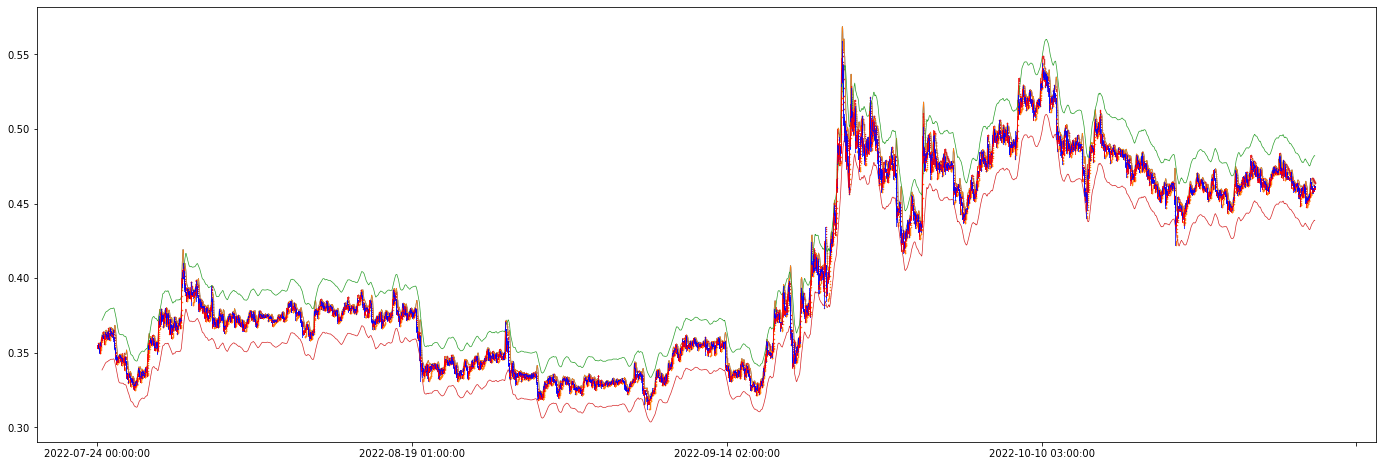

In [27]:
fig = plt.figure(figsize=(24, 8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # 색 지정 편하게

ax = fig.add_subplot(111)
index = df["Open_time"].astype("str") # 캐늗ㄹ스틱 축이 str로 드가

ax.plot(index, df['Bollinger_Band_20upper_2'], label='Bollinger_Band_20upper_2', linewidth=0.7)
ax.plot(index, df['Bollinger_Band_20upper_2'], label='Bollinger_Band_20lower_2', linewidth=0.7) # 하단선에서 2% 이하.
ax.plot(index, df['envelop_high_37_4.7'], label='envelop_high_37_4.7', linewidth=0.7)
ax.plot(index, df['envelop_low_37_4.7'], label='envelop_low_37_4.7', linewidth=0.7)

# psar
psar_bull = df.loc[df['Trend']==1]['PSAR']
psar_bear = df.loc[df['Trend']==0]['PSAR']
ax.scatter(psar_bull.index, psar_bull, s = 1,color=colors[1], label='PSAR Up Trend',linewidths = 0.5)
ax.scatter(psar_bear.index, psar_bear, s = 1,color=colors[3], label='PSAR Down Trend',linewidths = 0.5)

ax.xaxis.set_major_locator(ticker.MaxNLocator(5))

mpl_finance.candlestick2_ohlc(ax, df['Open'], df['High'], df['Low'], df['Close'], width=0.5, colorup='r', colordown='b')

In [28]:
df = data[bin_sym_name[sym_i]].copy()

BB_nearing_per_upper = 0.02 #주가 근접할 %
BB_nearing_per_lower = 0.01 #주가 근접할 %
envelop_nearing_per_upper = 0.01 #주가 근접할 %

diff_day = 5# 몇일 기준으로 볼것인지

df_1 = df.loc[df['Open_time'].between((df.iloc[-1:,]["Open_time"] - dt.timedelta(days=diff_day)).values[0],df.iloc[-1:,]["Open_time"].values[0])]

In [36]:
start_date = (now_time - diff_days).strftime('%Y-%m-%d %H:%i:%s') # 오늘 부터 몇 일 전

NameError: name 'now_time' is not defined

In [35]:
df.iloc[-1:,]["Open_time"]

9669   2022-11-01 17:15:00
Name: Open_time, dtype: datetime64[ns]

In [ ]:
df_1 = df.loc[df['Open_time'].between((df.iloc[-1:,]["Open_time"] - dt.timedelta(days=diff_day)).values[0],df.iloc[-1:,]["Open_time"].values[0])]

In [29]:
# 분봉상 기준.. 
logic_1 = df_1["Bollinger_Band_20upper_2"] * (1-BB_nearing_per_upper) >df_1["Close"] #볼벤 20 , 2 상한선 근접 or 돌파
print(sum(logic_1))
logic_1 = sum(logic_1)>1

logic_2 = df_1["envelop_high_37_4.7"] * (1-envelop_nearing_per_upper) >df_1["Close"] #엔벨로프 37,4.7 상한선 근접 or 돌파
print(sum(logic_2))
logic_2 = sum(logic_2)>1

logic_3 = df_1["envelop_high_37_3.8"] * (1-envelop_nearing_per_upper) >df_1["Close"] #엔벨로프 37, 3.8 상한선 돌파
print(sum(logic_3))
logic_3 = sum(logic_3)>1

# logic_4 = df_1["Bollinger_Band_20lower_2"] * (1-BB_nearing_per_lower) >df_1["Low"] #엔벨로프 37, 3.8 상한선 돌파
logic_4 = df_1["Bollinger_Band_20lower_2"] * (1-BB_nearing_per_lower) >df_1["Close"] #엔벨로프 37, 3.8 상한선 돌파
print(sum(logic_4))
logic_4 = sum(logic_4)>1

logic_5 = ( # 파라볼릭.
#             df_1["Trend"].diff().value_counts()[1] > 2 and # 상승추세 2번
#             df_1["Trend"].diff().value_counts()[-1] > 1 and # 하락추세 1번
            1 == df_1.iloc[-1:].Trend.values[0] # 지금은 상승중
            ) # 하락추세 1번 # 지금은 상승중

print(logic_1,logic_2,logic_3,logic_4,logic_5)

48
481
481
0
True True True False False


In [412]:
# 일봉상 기준.. 
logic_1 = df_1["Bollinger_Band_20upper_2"] * (1-BB_nearing_per_upper) >df_1["Close"] #볼벤 20 , 2 상한선 근접 or 돌파
print(sum(logic_1))
logic_1 = sum(logic_1)>1

logic_2 = df_1["envelop_high_37_4.7"] * (1-envelop_nearing_per_upper) >df_1["Close"] #엔벨로프 37,4.7 상한선 근접 or 돌파
print(sum(logic_2))
logic_2 = sum(logic_2)>1

logic_3 = df_1["envelop_high_37_3.8"] * (1-envelop_nearing_per_upper) >df_1["Close"] #엔벨로프 37, 3.8 상한선 돌파
print(sum(logic_3))
logic_3 = sum(logic_3)>1

# logic_4 = df_1["Bollinger_Band_20lower_2"] * (1-BB_nearing_per_lower) >df_1["Low"] #엔벨로프 37, 3.8 상한선 돌파
logic_4 = df_1["Bollinger_Band_20lower_2"] * (1-BB_nearing_per_lower) >df_1["Close"] #엔벨로프 37, 3.8 상한선 돌파
print(sum(logic_4))
logic_4 = sum(logic_4)>1

logic_5 = ( # 파라볼릭.
#             df_1["Trend"].diff().value_counts()[1] > 2 and # 상승추세 2번
#             df_1["Trend"].diff().value_counts()[-1] > 1 and # 하락추세 1번
            1 == df_1.iloc[-1:].Trend.values[0] # 지금은 상승중
            ) # 하락추세 1번 # 지금은 상승중

print(logic_1,logic_2,logic_3,logic_4,logic_5)

False

True True True False True


In [321]:
# df = df.dropna() # @@ 나중에 안해도 될 듯.
df = df.astype({"Trend":"int"})

In [322]:
df["Trend"].value_counts()

0    493
1    468
Name: Trend, dtype: int64

In [387]:
df["Trend"].diff().value_counts()

 0.0    881
 1.0     40
-1.0     39
Name: Trend, dtype: int64

In [392]:
# 상승추세 2번 # 하락추세 1번 # 지금은 상승중

True

In [233]:
df_1 = df.loc[df['Open_time'].between((df.iloc[-1:,]["Open_time"] - dt.timedelta(days=diff_day)).values[0],df.iloc[-1:,]["Open_time"].values[0])]

In [236]:
df_1[close_or_open]

8706    0.4893
8707    0.4897
8708    0.4882
8709    0.4909
8710    0.4903
         ...  
9662    0.4690
9663    0.4673
9664    0.4695
9665    0.4686
9666    0.4674
Name: Close, Length: 961, dtype: float64

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,...,Bollinger_Band_20lower_2,envelop_high_37_4.7,envelop_low_37_4.7,envelop_high_37_3.8,envelop_low_37_3.8,PSAR,EP,Trend,AF,PSAR_SAR_0.017_0.17
8706,2022-10-07 16:30:00,0.4886,0.4900,0.4882,0.4893,1913708.0,9.363105e+05,1297,962962.0,4.711010e+05,...,0.485943,0.512829,0.466787,0.508421,0.471195,0.490494,0.4849,0.0,0.04,0.490494
8707,2022-10-07 16:45:00,0.4894,0.4903,0.4890,0.4897,1630005.0,7.981694e+05,1137,771049.0,3.776262e+05,...,0.485978,0.512688,0.466658,0.508281,0.471065,0.484900,0.4903,1.0,0.02,0.484900
8708,2022-10-07 17:00:00,0.4896,0.4897,0.4880,0.4882,2267142.0,1.108195e+06,1396,721289.0,3.525342e+05,...,0.486098,0.512580,0.466560,0.508174,0.470967,0.485008,0.4903,1.0,0.02,0.485008
8709,2022-10-07 17:15:00,0.4881,0.4932,0.4879,0.4909,4107015.0,2.016884e+06,3027,2166800.0,1.063956e+06,...,0.486194,0.512546,0.466530,0.508140,0.470935,0.485114,0.4932,1.0,0.04,0.485114
8710,2022-10-07 17:30:00,0.4910,0.4922,0.4901,0.4903,2786003.0,1.368240e+06,1700,1159935.0,5.697381e+05,...,0.486201,0.512487,0.466475,0.508081,0.470881,0.485437,0.4932,1.0,0.04,0.485437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9662,2022-10-17 15:30:00,0.4682,0.4698,0.4680,0.4690,2124796.0,9.965289e+05,1928,1429303.0,6.702489e+05,...,0.464867,0.493782,0.449450,0.489538,0.453695,0.464976,0.4725,1.0,0.04,0.464976
9663,2022-10-17 15:45:00,0.4690,0.4695,0.4666,0.4673,2815866.0,1.316952e+06,1916,1823073.0,8.525486e+05,...,0.465159,0.493502,0.449195,0.489260,0.453437,0.465277,0.4725,1.0,0.04,0.465277
9664,2022-10-17 16:00:00,0.4673,0.4706,0.4672,0.4695,4565495.0,2.142617e+06,3343,1966511.0,9.225872e+05,...,0.465397,0.493434,0.449133,0.489193,0.453375,0.465566,0.4725,1.0,0.04,0.465566
9665,2022-10-17 16:15:00,0.4694,0.4696,0.4674,0.4686,1891740.0,8.861552e+05,1652,839040.0,3.930755e+05,...,0.465450,0.493194,0.448915,0.488954,0.453154,0.465843,0.4725,1.0,0.04,0.465843


In [32]:
df['Open_time']

0      2022-07-24 00:00:00
1      2022-07-24 00:15:00
2      2022-07-24 00:30:00
3      2022-07-24 00:45:00
4      2022-07-24 01:00:00
               ...        
9665   2022-11-01 16:15:00
9666   2022-11-01 16:30:00
9667   2022-11-01 16:45:00
9668   2022-11-01 17:00:00
9669   2022-11-01 17:15:00
Name: Open_time, Length: 9670, dtype: datetime64[ns]

In [33]:

df.loc[df['Open_time'].between("2022-05-01","2022-11-01")]

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,...,Bollinger_Band_20lower_2,envelop_high_37_4.7,envelop_low_37_4.7,envelop_high_37_3.8,envelop_low_37_3.8,PSAR,EP,Trend,AF,PSAR_SAR_0.017_0.17
0,2022-07-24 00:00:00,0.3534,0.3555,0.3532,0.3552,1487889.0,5.276243e+05,1250,785128.0,2.783774e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,0.3555,NaN,0.02,NaN
1,2022-07-24 00:15:00,0.3552,0.3553,0.3535,0.3538,1054541.0,3.739812e+05,900,423040.0,1.500132e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,0.3553,NaN,0.02,NaN
2,2022-07-24 00:30:00,0.3538,0.3549,0.3533,0.3542,1323092.0,4.685651e+05,930,600935.0,2.128406e+05,...,NaN,NaN,NaN,NaN,NaN,0.355500,0.3532,0.0,0.02,0.355500
3,2022-07-24 00:45:00,0.3542,0.3549,0.3538,0.3548,1262203.0,4.472599e+05,1033,643335.0,2.279375e+05,...,NaN,NaN,NaN,NaN,NaN,0.355454,0.3532,0.0,0.02,0.355454
4,2022-07-24 01:00:00,0.3548,0.3556,0.3543,0.3555,1465355.0,5.199971e+05,1088,761912.0,2.704040e+05,...,NaN,NaN,NaN,NaN,NaN,0.353300,0.3556,1.0,0.02,0.353300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9596,2022-10-31 23:00:00,0.4506,0.4535,0.4497,0.4522,6957400.0,3.142554e+06,6262,3408251.0,1.539695e+06,...,0.452999,0.479679,0.436613,0.475555,0.440736,0.460800,0.4497,0.0,0.10,0.460800
9597,2022-10-31 23:15:00,0.4522,0.4539,0.4512,0.4516,4182640.0,1.892560e+06,3071,1905431.0,8.621713e+05,...,0.451883,0.479447,0.436402,0.475325,0.440523,0.459700,0.4497,0.0,0.10,0.459700
9598,2022-10-31 23:30:00,0.4515,0.4523,0.4476,0.4522,5951808.0,2.677474e+06,4805,2580651.0,1.161532e+06,...,0.450983,0.479220,0.436196,0.475101,0.440315,0.458700,0.4476,0.0,0.12,0.458700
9599,2022-10-31 23:45:00,0.4523,0.4524,0.4510,0.4517,3745816.0,1.691861e+06,2283,1610967.0,7.276245e+05,...,0.450181,0.479014,0.436008,0.474896,0.440125,0.457368,0.4476,0.0,0.12,0.457368


In [35]:
val = df.iloc[-1]
if ((val["단순이동평균_Close6"]>val["단순이동평균_Close20"]>val["단순이동평균_Close37"]>val["단순이동평균_Close74"])&(val["단순이동평균_Close6"]>val["단순이동평균_Close37"]>val["단순이동평균_Close74"])&(val["단순이동평균_Close6"]>val["단순이동평균_Close20"]>val["단순이동평균_Close149"])
and(1 == 1)):
    print(True)

In [108]:

# 지수 이동 평균(Exponential Moving Average, EMA)
def EMA(data, period=3, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

def WMA(data, period=3, column='Close'): #가중이동평균
    val = []
    for i in range(WINDOW):
        val.append(None)

    for i in range(len(data)-period):
        df = data[[column]].loc[i+1:i+period].reset_index(drop = True)
        sum_count_1 = 0
        sum_count_2 = 0
        for j in range(period):
            sum_count_1 = sum_count_1 + (j+1) * float(df.iloc[j].values)
            sum_count_2 = sum_count_2 + (j+1)
        val.append(sum_count_1/sum_count_2)
    return val

def LSMA(data, period=3, column='Close'): # 최소제솝평균..

    val = []
    for i in range(WINDOW):
        val.append(None)

    for i in range(len(data)-period):
        df = data[[column]].loc[i+1:i+period].reset_index(drop = True)
        X = [k+1 for k in range(period)]
        Y = [float(df.iloc[k]) for k in range(period)]
        LRS = (len(X) * sum([X[i]*Y[i] for i in range(len(X))])- sum(X)*sum(Y)) /(len(X) * sum([X[i]*X[i] for i in range(len(X))]) - sum(X) * sum(X))
        LRT = (sum(Y) - LRS * sum(X)) / (len(X))
        LRI = LRT + LRS * len(X)
        val.append(LRI)

    return val

# data, period, column = data, WINDOW, '종가'
def triangular_weighted_moving_average(data, period=20, column='Close'):
    
    val = []
    for i in range(WINDOW):
        val.append(None)

    for i in range(len(data)-period):
        df = data[[column]].loc[i+1:i+period].reset_index(drop = True)
        
        A = int(np.ceil((period+0.1)/2)) # N기간을 2로나눔 (소수점 반올림)
        B = float(df.iloc[0:A].mean()) #A기간동안의 이동평균값
        for_Trima = list(df[column].values)
        for_Trima.insert(0, B)
        Trima = np.mean(for_Trima)#B값의 A기간 이동평균값
        val.append(np.mean(Trima))
        
    return val

In [106]:
data[["단순이동평균_"+"시가"]] = SMA(data, period=WINDOW, column='오픈')
data[["지수이동평균_"+"시가"]] = EMA(data, period=WINDOW, column='오픈')
data[["가중이동평균_"+"시가"]] = WMA(data, period=WINDOW, column='오픈')
data[["최소제곱평균_"+"시가"]] = LSMA(data, period=WINDOW, column='오픈')
data[["삼각이동평균_"+"시가"]] = triangular_weighted_moving_average(data, period=WINDOW, column='오픈')


,Open_time,Close,Volume
0,2022-09-24 01:00:00,0.4718,124726569.0
1,2022-09-24 03:00:00,0.4716,97905674.0
2,2022-09-24 05:00:00,0.5157,148967612.0
3,2022-09-24 07:00:00,0.5069,155948863.0
4,2022-09-24 09:00:00,0.5019,97321401.0
...,...,...,...
121,2022-10-04 03:00:00,0.4553,21513584.0
122,2022-10-04 05:00:00,0.4613,53975616.0
123,2022-10-04 07:00:00,0.4621,33093730.0
124,2022-10-04 09:00:00,0.4560,28850500.0


In [ ]:



diff_days

In [24]:
now_day_time

'2022-10-04'

In [30]:
now_time - diff_days

datetime.datetime(2022, 6, 26, 11, 2, 13, 944401)

datetime.timedelta(days=10)

In [28]:
now_day_time - diff_days

TypeError: unsupported operand type(s) for -: 'str' and 'datetime.timedelta'

In [23]:

current_time

'11:02:32'